In [5]:
import pandas as pd
import numpy as np

from src.scripts import smiles
from src.scripts import targets
from src.utils import utils

%load_ext autoreload

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import plotly.graph_objects as go
from matplotlib.patches import Patch

# learning
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# rdkit tools
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

import json
from tqdm import tqdm

tqdm.pandas()

# Looking at a sample

In [ ]:
mol_df = (
    pd.read_csv(
        "../data/BindingDB_All.tsv",
        sep="\t",
        usecols=[
            "BindingDB Reactant_set_id",
            "Ligand SMILES",
            "BindingDB Ligand Name",
            "IC50 (nM)",
            "UniProt (SwissProt) Primary ID of Target Chain",
        ],
    )
    .dropna()
    .sample(10000, random_state=0)
)

In [ ]:
descriptors = mol_df["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
isdict = lambda x: isinstance(x, dict)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(isdict)].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)

In [ ]:
to_drop = utils.collinear_cols(descriptors_df, threshold=0.9)
print(descriptors_df.columns.to_list())
print(to_drop)
print(len(to_drop))

In [23]:
descriptors_df

,Molecular Weight,C LogP,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,...,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons
1493227,447.501,4.20550,0.458333,-2.74,32.0,419.277,1.610108e+07,22.453803,9.402350,5.176748,...,2.0,4.0,0.0,8.0,0.0,6.0,0.0,1.0,1.0,172.0
384364,413.507,1.76940,0.473684,-2.59,29.0,390.323,7.452830e+06,18.439320,7.342386,3.815837,...,2.0,9.0,2.0,10.0,0.0,4.0,1.0,2.0,3.0,152.0
1577050,592.700,5.19628,0.181818,-5.01,43.0,563.468,5.148955e+09,29.481271,13.313440,7.640180,...,5.0,8.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,216.0
977575,762.685,7.66038,0.375000,-4.47,53.0,723.373,8.137545e+11,36.870152,16.269416,8.847310,...,4.0,8.0,2.0,13.0,0.0,15.0,0.0,2.0,2.0,276.0
670060,372.428,4.72010,0.136364,-3.67,28.0,352.268,3.293984e+06,17.729330,7.520458,3.572130,...,4.0,6.0,1.0,6.0,0.0,5.0,0.0,0.0,0.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325491,404.257,3.30138,0.277778,-2.69,27.0,389.137,1.995341e+06,17.710308,6.798781,2.910251,...,3.0,5.0,2.0,9.0,0.0,4.0,0.0,0.0,0.0,138.0
2427929,316.455,2.93580,0.333333,-1.50,21.0,300.327,1.342867e+05,13.182963,5.363905,2.661712,...,3.0,6.0,1.0,6.0,0.0,2.0,0.0,0.0,0.0,108.0
1503242,405.506,2.79392,0.409091,-3.13,30.0,378.290,6.572977e+06,20.155338,8.314052,4.088769,...,3.0,8.0,1.0,8.0,0.0,4.0,0.0,1.0,1.0,156.0
1996056,199.257,1.47600,0.250000,-1.79,15.0,186.153,4.014255e+03,9.753174,4.157882,2.171589,...,2.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,76.0


In [29]:
normilzed_df = (
    descriptors_df / descriptors_df["Molecular Weight"].to_numpy().reshape(10000, 1)
).drop("Molecular Weight", axis=1)
to_drop = utils.collinear_cols(normilzed_df, threshold=0.9)
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(normilzed_df.dropna())
    .drop(to_drop, axis=1)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = (
    (smiles.get_IC50(mol_df.loc[X.index])).replace([np.inf, -np.inf], np.nan).dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.664
Date:                Tue, 03 Dec 2024   Prob (F-statistic):             0.0153
Time:                        16:09:23   Log-Likelihood:            -1.7716e+05
No. Observations:                9988   AIC:                         3.544e+05
Df Residuals:                    9959   BIC:                         3.546e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C LogP                  

In [ ]:
sns.pairplot(
    pd.merge(descriptors_df, mol_df, how="inner", left_index=True, right_index=True)[
        [
            "Molecular Weight",
            "NumAromaticRings",
            "NumHAcceptors",
            "NumHDonors",
            "NumHeteroatoms",
            "NumRotatableBonds",
            "NumSaturatedCarbocycles",
            "NumSaturatedHeterocycles",
            "NumSaturatedRings",
            "NumValenceElectrons",
            "IC50 (nM)",
        ]
    ].sample(100, random_state=0)
)

In [51]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.sample(5000, random_state=0).dropna())
)
y = smiles.get_IC50(mol_df.loc[X.index])

In [56]:
mol_df["IC50 (nM)"] = smiles.get_IC50(mol_df)

In [ ]:
import statsmodels.api as sm

model = sm.OLS(endog=y, exog=X, hasconst=True)
np.random.seed(42)
model = model.fit()
print(model.summary())

In [ ]:
descriptors_df

In [ ]:
descriptors_df.index

In [30]:
%autoreload 2

In [ ]:
pd.merge(descriptors_df, mol_df, how="inner", left_index=True, right_index=True)

# Restricting to one protein

In [30]:
# target_df = mol_df[
#     mol_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
# ].drop_duplicates('Ligand SMILES')#dropna(subset=["Ligand SMILES", "IC50 (nM)"])

target_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
    ],
).drop_duplicates("Ligand SMILES")
target_df["IC50 (nM)"] = smiles.get_IC50(target_df)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_73745/1032142100.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [31]:
target_df = target_df[
    target_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]
descriptors = target_df["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
isdict = lambda x: isinstance(x, dict)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(isdict)].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
merged_df = pd.merge(
    target_df, descriptors_df, how="inner", left_index=True, right_index=True
)

 67%|██████▋   | 2621/3907 [00:17<00:07, 160.98it/s][16:11:15] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[16:11:15] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
100%|██████████| 3907/3907 [00:24<00:00, 162.27it/s]


In [ ]:
from sklearn.preprocessing import StandardScaler

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = (
    (smiles.get_IC50(target_df.loc[X.index]))
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit_regularized(alpha=100)
print(model.summary())

In [36]:
to_drop

['MaxEStateIndex',
 'MinAbsPartialCharge',
 'MinPartialCharge',
 'MolLogP',
 'NumHDonors',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings']

In [38]:
normilzed_df = (
    descriptors_df / descriptors_df["Molecular Weight"].to_numpy().reshape(3907, 1)
).drop("Molecular Weight", axis=1)
target_df = target_df[
    target_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]
to_drop = utils.collinear_cols(normilzed_df, threshold=0.9)
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(normilzed_df.dropna())
    .drop(to_drop, axis=1)
    .dropna()
)
y = (
    (smiles.get_IC50(target_df.loc[X.index]))
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     9.475
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           3.54e-35
Time:                        16:13:53   Log-Likelihood:                -42316.
No. Observations:                3899   AIC:                         8.468e+04
Df Residuals:                    3873   BIC:                         8.485e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C LogP                  

In [ ]:
print(y.isna().sum())  # Check for missing values
print(y.isin([np.inf, -np.inf]).sum())  # Check for infinite values

In [ ]:
sns.pairplot(
    merged_df[
        [
            "Molecular Weight",
            "NumAromaticRings",
            "NumHAcceptors",
            "NumHDonors",
            "NumHeteroatoms",
            "NumRotatableBonds",
            "NumSaturatedCarbocycles",
            "NumSaturatedHeterocycles",
            "NumSaturatedRings",
            "NumValenceElectrons",
            "Kappa1",
            "IC50 (nM)",
        ]
    ].sample(500, random_state=0)
)

In [ ]:
merged_df["IC50 (nM)"]

In [151]:
target_df["IC50 (nM)"] += 1

In [ ]:
np.logspace(0, 6, 7)

In [ ]:
ax = sns.histplot(target_df, x="IC50 (nM)", bins=np.logspace(0, 6, 7))
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
np.log(smiles.get_IC50(target_df.loc[X.index]))

In [ ]:
corr_matrix = X.corr()
print(corr_matrix)  # .to_numpy().diagonal())

# Summary regularized

In [ ]:
from sklearn.preprocessing import StandardScaler

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = (
    (smiles.get_IC50(target_df.loc[X.index]))
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit_regularized(alpha=10000)
model.params

In [ ]:
results = []
for i in np.logspace(0, 4, 40):
    model = sm.OLS(endog=y, exog=X, hasconst=True).fit_regularized(alpha=i)
    results.append(model.params)
results_df = pd.DataFrame(results)
results_df.index = np.logspace(0, 4, len(results))
results_df

In [ ]:
import plotly.express as px

# Plot the line plot using Plotly Express
fig = px.line(
    results_df,
    title="Line Plot with Logarithmic X-Axis",
    labels={"x": "X-Axis Label", "y": "Y-Axis Label"},
)

# Set the x-axis to logarithmic scale
fig.update_layout(xaxis_type="log")

# Show the plot
fig.show()

In [ ]:
# Plot the line plot using Plotly Express
fig = px.line(
    np.abs(results_df).sum(axis=1),
    title="Line Plot with Logarithmic X-Axis",
    labels={"x": "X-Axis Label", "y": "Y-Axis Label"},
)

# Set the x-axis to logarithmic scale
fig.update_layout(xaxis_type="log")

# Show the plot
fig.show()

# Looking with citations

In [242]:
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations).sort_values(by="citation", ascending=False)

In [ ]:
target_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Article DOI",
    ],
).drop_duplicates("Ligand SMILES")
target_df["IC50 (nM)"] = smiles.get_IC50(target_df)

In [ ]:
citations_df

In [269]:
target_df = pd.merge(target_df, citations_df, left_on="Article DOI", right_on="doi")

In [ ]:
target_df.drop("IC50 (nM)", axis=1).dropna()

In [ ]:
ret_df = target_df.drop("IC50 (nM)", axis=1).dropna()[
    target_df.drop("IC50 (nM)", axis=1).dropna()[
        "UniProt (SwissProt) Primary ID of Target Chain"
    ]
    == "P07949"
]
descriptors = ret_df["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
isdict = lambda x: isinstance(x, dict)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(isdict)].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
ret_df = pd.merge(
    ret_df, descriptors_df, how="inner", left_index=True, right_index=True
)

In [ ]:
ret_df

In [ ]:
ret_df["citation"]

In [319]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = ret_df["citation"] > ret_df["citation"].mean()  # Rep
X = X.loc[y.index]
model = LogisticRegression(penalty="l1", C=1, solver="liblinear").fit(X, y)

In [ ]:
model.coef_.reshape(38)

In [ ]:
ax = sns.histplot(ret_df, x="citation")
# ax.set_xscale('log')

In [ ]:
results = []
for i in np.logspace(0, 1, 40):
    model = LogisticRegression(
        penalty="l1", C=1 / (i - 0.99999), solver="liblinear"
    ).fit(X, y)
    results.append(model.coef_.reshape(38))
results_df = pd.DataFrame(
    np.stack(results), index=np.logspace(0, 4, len(results)), columns=X.columns
)


fig = px.line(
    results_df,
    title="Lasso plot of coefs",
    labels={"x": "alpha regularisation strength", "y": "coefs"},
)

# Set the x-axis to logarithmic scale
fig.update_layout(xaxis_type="log")

# Show the plot
fig.show()

In [ ]:
for res in results()

In [ ]:
model.coef_.shape

In [ ]:
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()
print(model.summary())

# Fingerprints

In [ ]:
sample_df = target_df.dropna().sample(int(1e4), random_state=0)
sample_df[[f"FP{i}" for i in np.arange(2048)]] = np.stack(
    sample_df["Ligand SMILES"].progress_apply(smiles.get_fingerprint)
)

In [ ]:
print(model.summary())

In [ ]:
ret_df = target_df[
    target_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]
ret_df[[f"FP{i}" for i in np.arange(2048)]] = np.stack(
    ret_df["Ligand SMILES"].apply(smiles.get_fingerprint)
)

In [435]:
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(ret_df[[f"FP{i}" for i in np.arange(2048)]])
)  # .replace([np.inf, -np.inf], np.nan).dropna()#[['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
pca = PCA(200).set_output(transform="pandas")
X = pca.fit_transform(X)
# y=ret_df['citation'].dropna()
y = smiles.get_IC50(target_df.loc[X.index]).dropna()
X = X.loc[y.index]
# model = Lasso(alpha=0).fit(X,y)
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()

In [57]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso

In [41]:
ligand_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
    ],
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_73745/1808430885.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [68]:
# Loading Descriptors
descriptors = (
    ligand_df.dropna()["Ligand SMILES"]
    .sample(10000)
    .progress_apply(smiles.get_MolDescriptors)
)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(lambda x: isinstance(x, dict))].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
to_drop = utils.collinear_cols(descriptors_df, threshold=0.9)

 16%|█▌        | 1575/10000 [00:11<00:45, 186.29it/s][16:50:47] Can't kekulize mol.  Unkekulized atoms: 20 21 23 24 26
[16:50:47] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
100%|██████████| 10000/10000 [00:59<00:00, 167.51it/s]


In [89]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


numerical_cols = [
    "Molecular Weight",
    "C LogP",
    "FractionCSP3",
    "HallKierAlpha",
    "HeavyAtomCount",
    "HeavyAtomMolWt",
    "Ipc",
    "Kappa1",
    "Kappa2",
    "Kappa3",
    "LabuteASA",
    "MaxAbsEStateIndex",
    "MaxAbsPartialCharge",
    "MaxEStateIndex",
    "MaxPartialCharge",
    "MinAbsEStateIndex",
    "MinAbsPartialCharge",
    "MinEStateIndex",
    "MinPartialCharge",
    "MolLogP",
    "MolMR",
]
categorical_cols = [
    "NHOHCount",
    "NOCount",
    "NumAliphaticCarbocycles",
    "NumAliphaticHeterocycles",
    "NumAliphaticRings",
    "NumAromaticCarbocycles",
    "NumAromaticHeterocycles",
    "NumAromaticRings",
    "NumHAcceptors",
    "NumHDonors",
    "NumHeteroatoms",
    "NumRadicalElectrons",
    "NumRotatableBonds",
    "NumSaturatedCarbocycles",
    "NumSaturatedHeterocycles",
    "NumSaturatedRings",
    "NumValenceElectrons",
]


# Preprocessing for numeric features

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# Preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
)

# Combine preprocessors into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Build the complete pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ('model', Lasso(alpha=alpha))
    ]
).set_output(transform="pandas")

X = pipeline.fit_transform(descriptors_df.dropna())
y = smiles.get_IC50(ligand_df.iloc[X.index])

In [92]:
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.341
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.35e-06
Time:                        17:01:48   Log-Likelihood:            -1.7575e+05
No. Observations:                9976   AIC:                         3.525e+05
Df Residuals:                    9487   BIC:                         3.560e+05
Df Model:                         488                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
num_

## Just in RET

In [93]:
descriptors = ligand_df.dropna()[
    ligand_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
ret_descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(lambda x: isinstance(x, dict))].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
X = pipeline.fit_transform(ret_descriptors_df.dropna())
y = smiles.get_IC50(ligand_df.iloc[X.index])
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()
print(model.summary())

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_73745/794838224.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  descriptors=ligand_df.dropna()[ligand_df['UniProt (SwissProt) Primary ID of Target Chain']=='P07949']['Ligand SMILES'].progress_apply(smiles.get_MolDescriptors)
 12%|█▏        | 3077/26363 [00:20<02:35, 150.16it/s][17:04:55] Explicit valence for atom # 35 N, 4, is greater than permitted
[17:04:55] Explicit valence for atom # 35 N, 4, is greater than permitted
 48%|████▊     | 12541/26363 [01:26<01:11, 192.57it/s][17:06:01] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[17:06:01] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
 67%|██████▋   | 17760/26363 [02:05<01:04, 133.55it/s][17:06:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:06:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:06:40] Explicit valence for atom # 17 N, 4, is greater than permitted
100%|██████████| 26363/2636

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     19.37
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:07:37   Log-Likelihood:            -2.6483e+05
No. Observations:               26352   AIC:                         5.301e+05
Df Residuals:                   26143   BIC:                         5.318e+05
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
num__M

# Random Forest

In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [67]:
ligand_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Article DOI",
    ],
)
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations).sort_values(by="citation", ascending=False)
ligand_df = pd.merge(ligand_df, citations_df, left_on="Article DOI", right_on="doi")

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_92558/1261252199.py:2: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [6]:
descriptors = ligand_df.dropna()[
    ligand_df["UniProt (SwissProt) Primary ID of Target Chain"] == "O60674"
]["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(lambda x: isinstance(x, dict))].to_list(),
    index=descriptors[descriptors.apply(lambda x: isinstance(x, dict))].index,
)
to_drop = utils.collinear_cols(descriptors_df, threshold=0.9)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_92558/2370459953.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  descriptors=ligand_df.dropna()[ligand_df['UniProt (SwissProt) Primary ID of Target Chain']=='O60674']['Ligand SMILES'].progress_apply(smiles.get_MolDescriptors)
100%|██████████| 3227/3227 [00:13<00:00, 233.24it/s]


In [7]:
X = descriptors_df.dropna().drop(
    ["MaxPartialCharge", "MaxAbsPartialCharge"], axis=1
)  # (descriptors_df/descriptors_df['Molecular Weight'].to_numpy().reshape(len(descriptors),1)).drop(['Molecular Weight']+to_drop,axis=1)
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()
y = pd.cut(y, bins=np.logspace(0, np.log(y.max()), num=10) - 1, labels=np.arange(9))

In [172]:
# Define the pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Step 1: Standardize features
        (
            "model",
            RandomForestClassifier(random_state=42),
        ),  # Step 2: Apply Random Forest
    ]
)

# Define cross-validation strategy
cv = KFold(n_splits=7, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="balanced_accuracy")

# Print results
print(f"Accuracies: {scores}")
print(f"Mean Accuracy: {scores.mean():.3f}")
print(f"Standard Deviation of Accuracies: {scores.std():.3f}")

Accuracies: [0.38279768 0.52481652 0.3847079  0.56823506 0.53287888 0.53466733
 0.47505045]
Mean Accuracy: 0.486
Standard Deviation of Accuracies: 0.070


## Plotting Trees

In [173]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming descriptors_df and ligand_df are pre-defined DataFrames
# Preparing the dataset
X = (
    descriptors_df.dropna()
)  # .drop(['MaxPartialCharge', 'MaxAbsPartialCharge'], axis=1)
X = StandardScaler().set_output(transform="pandas").fit_transform(X)
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()
y = pd.cut(
    y, bins=np.logspace(0, np.log(y.max()), num=10) - 1, labels=np.arange(9)
).dropna()
X = X.loc[y.index]

# Train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.95)
rf.fit(X, y)  # .drop(to_drop,axis=1), y)

RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=42)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_70895/572527279.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mdi_df.columns,rotation=90)


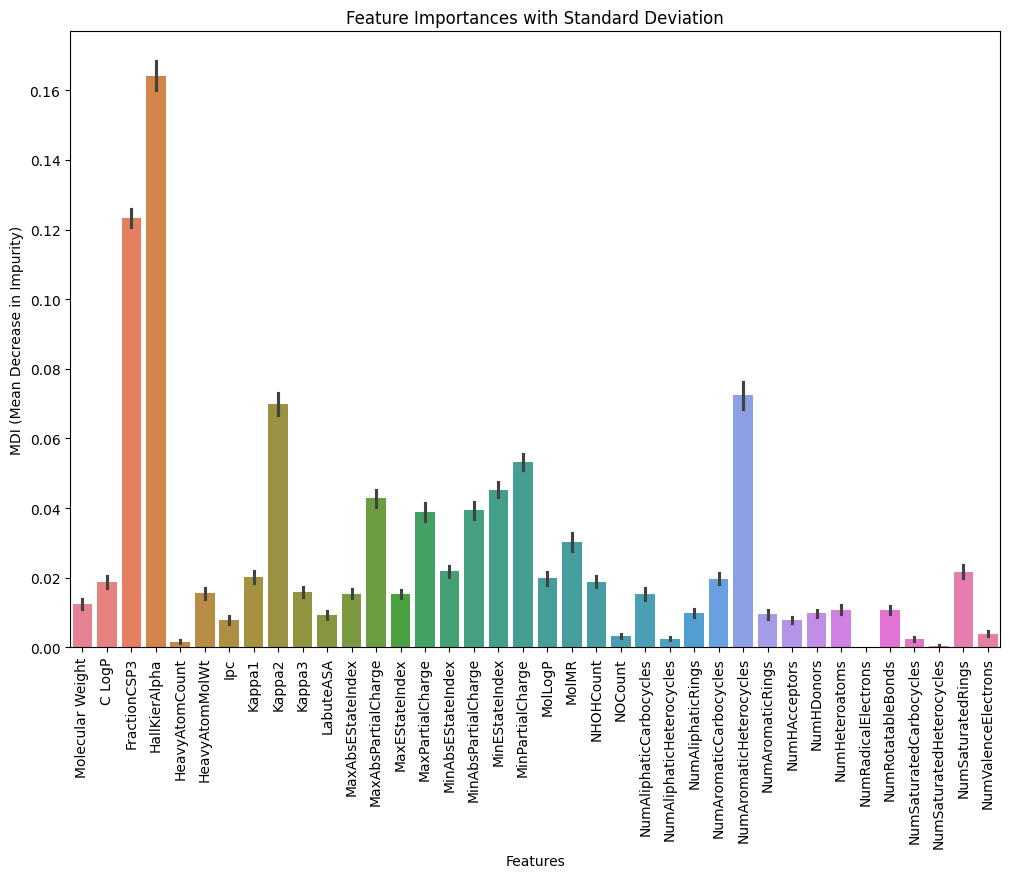

In [174]:
mdi_df = pd.DataFrame(
    data=[tree.feature_importances_ for tree in rf.estimators_], columns=X.columns
)  # drop(to_drop,axis=1).columns)

# Visualize the feature importances with Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=mdi_df,
)
ax.set_xticklabels(mdi_df.columns, rotation=90)
ax.set_ylabel("MDI (Mean Decrease in Impurity)")
ax.set_xlabel("Features")
ax.set_title("Feature Importances with Standard Deviation")
plt.show()

## Logistic Regression

In [59]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming descriptors_df and ligand_df are pre-defined DataFrames
# Preparing the dataset
X = (
    descriptors_df.dropna()
)  # .drop(['MaxPartialCharge', 'MaxAbsPartialCharge'], axis=1)
X = StandardScaler().set_output(transform="pandas").fit_transform(X)
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()
y = y[y < 2e5]
y = pd.cut(y, bins=np.logspace(0, 5, num=5) - 1, labels=np.arange(4)).dropna()
X = X.loc[y.index]

# Train the Random Forest Regressor
lr = LogisticRegression(max_iter=1000, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.95)
lr.fit(X.drop(to_drop, axis=1), y)

LogisticRegression(max_iter=1000, random_state=42)

In [63]:
y.value_counts()  # .sum()

IC50 (nM)
1    1073
2     867
0     830
3     418
Name: count, dtype: int64

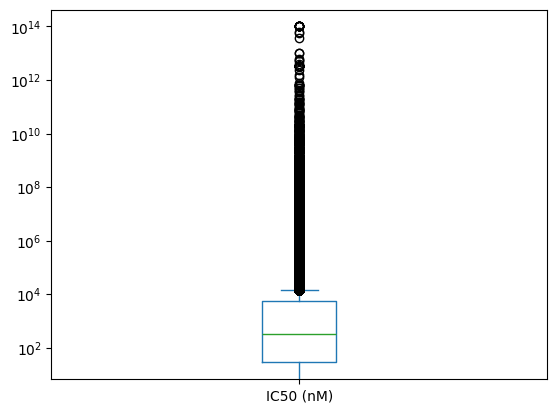

In [42]:
smiles.get_IC50(ligand_df).dropna().plot(kind="box")  # ,bins=np.logspace(0,8))
plt.yscale("log")

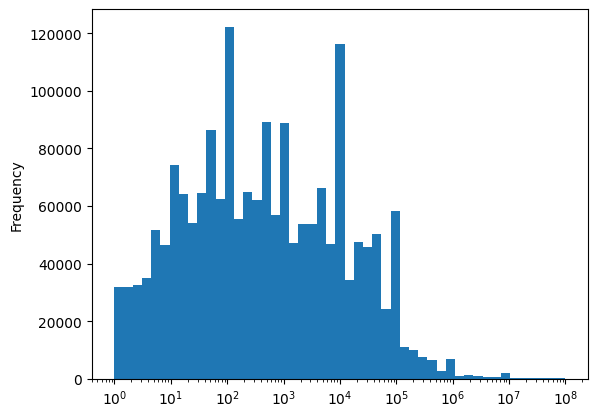

In [43]:
smiles.get_IC50(ligand_df).dropna().plot(kind="hist", bins=np.logspace(0, 8))
plt.xscale("log")

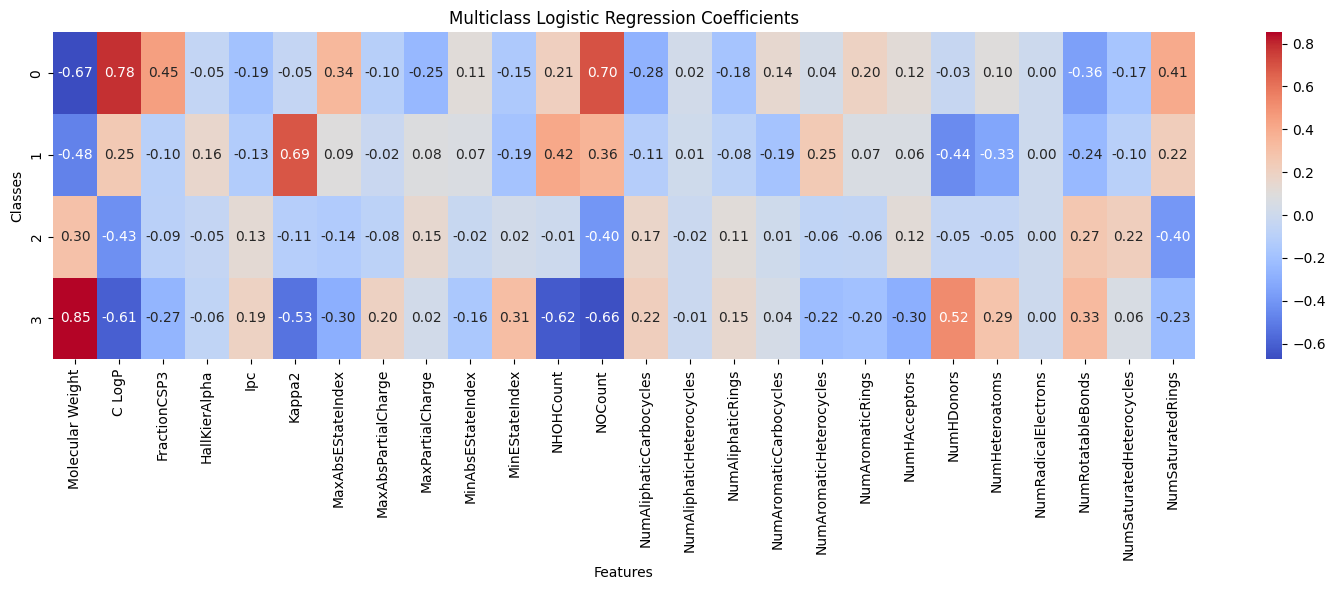

In [66]:
# Create a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(
    lr.coef_,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=X.drop(to_drop, axis=1).columns,
    yticklabels=np.arange(4),
)
plt.title("Multiclass Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

## Using Citations

In [78]:
descriptors_df

,Molecular Weight,C LogP,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,...,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons
31832,686.810,6.22484,0.378378,-5.27,50,640.442,1.201603e+11,36.021768,16.902563,8.653447,...,4,12,1,13,0,14,0,1,1,266
65217,281.363,3.13892,0.312500,-2.43,21,262.211,6.499958e+04,13.548364,4.547590,2.243747,...,3,5,1,5,0,1,0,0,0,108
153837,311.389,2.68168,0.529412,-2.42,23,290.221,2.496972e+05,15.474723,6.367984,2.912740,...,2,5,1,6,0,4,1,0,1,120
153838,309.344,3.99420,0.222222,-2.69,23,293.216,2.216981e+05,13.937662,4.410976,1.961629,...,4,2,2,5,0,0,0,0,0,116
153839,526.515,3.17340,0.296296,-4.12,38,501.315,2.875352e+08,25.526254,9.016109,4.425613,...,3,5,3,11,0,4,0,1,1,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832243,469.605,4.64040,0.461538,-2.97,34,433.317,3.037627e+07,25.649287,11.944486,6.545573,...,3,7,4,8,0,12,0,0,0,184
2832244,372.400,2.37210,0.263158,-3.13,27,351.232,9.769282e+05,18.654856,7.239935,3.563629,...,3,6,5,8,0,5,0,0,0,142
2842563,409.396,3.15850,0.142857,-3.88,30,392.260,7.803225e+06,19.437021,7.859895,3.567098,...,3,5,3,9,0,5,0,0,0,152
2842564,450.445,3.48620,0.208333,-3.85,33,430.285,4.918331e+07,21.019786,8.589562,4.025663,...,3,5,2,9,0,4,0,1,1,168


In [ ]:
ligand_df.merge(descriptors_df, left_index=True, right_index=True)

In [90]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming descriptors_df and ligand_df are pre-defined DataFrames
# Preparing the dataset
X = (
    descriptors_df.dropna()
)  # .drop(['MaxPartialCharge', 'MaxAbsPartialCharge'], axis=1)
X = StandardScaler().set_output(transform="pandas").fit_transform(X)
y = ligand_df.merge(descriptors_df, left_index=True, right_index=True)[
    "citation"
].dropna()  # .loc[X.index]
y = pd.cut(y, bins=np.linspace(0, 150, 4), labels=np.arange(3)).dropna()
X = X.loc[y.index]

# Train the Random Forest Regressor
lr = LogisticRegression(max_iter=1000, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.95)
lr.fit(X.drop(to_drop, axis=1), y)

LogisticRegression(max_iter=1000, random_state=42)

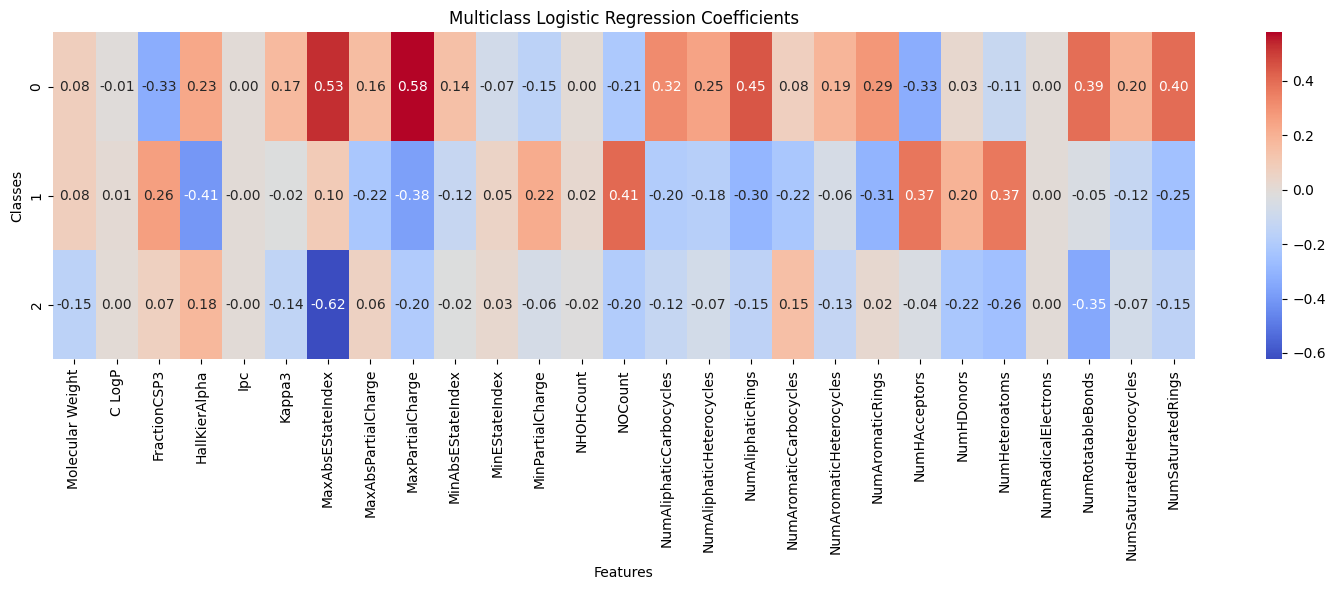

In [92]:
# Create a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(
    lr.coef_,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=X.drop(to_drop, axis=1).columns,
    yticklabels=np.arange(3),
)
plt.title("Multiclass Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

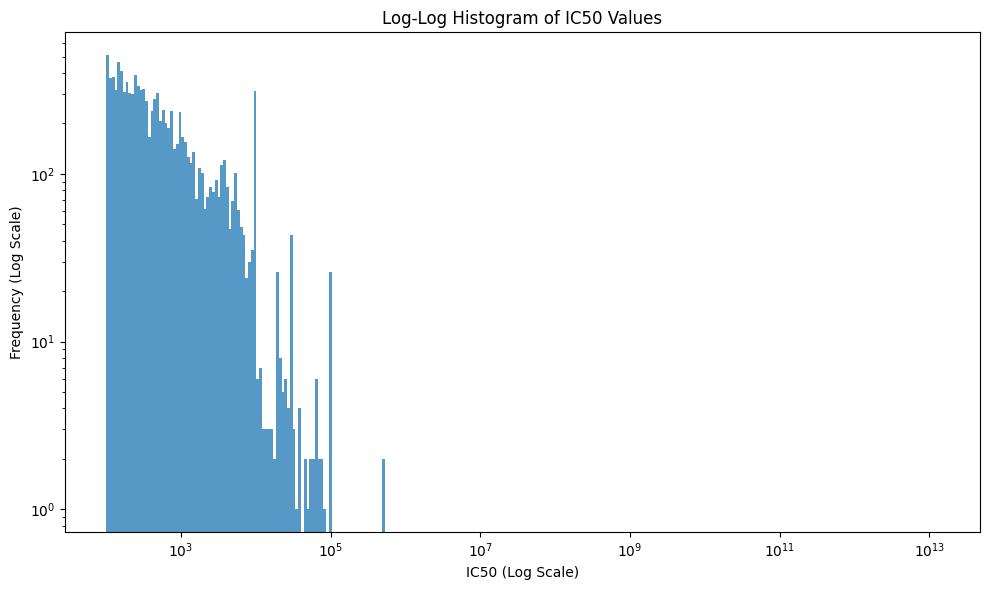

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y is already defined and cleaned
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(
    y, bins=np.logspace(2, np.log(y.max()), 300), kde=False
)  # kde=True adds a kernel density estimate curve

# Set logarithmic scales
plt.xscale("log")
plt.yscale("log")

# Add labels and title
plt.xlabel("IC50 (Log Scale)")
plt.ylabel("Frequency (Log Scale)")
plt.title("Log-Log Histogram of IC50 Values")

# Show the plot
plt.tight_layout()
plt.show()

In [135]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, DecisionTreeClassifier
import pandas as pd
import matplotlib.patches as mpatches  # For creating custom legend patches

# Handle y and class imbalance
y = smiles.get_IC50(ligand_df).dropna()
y = y > 1e3  # Convert to binary (True if IC50 > 1000, else False)

# Handle imbalance using class_weight
dt = DecisionTreeClassifier(max_depth=1, class_weight="balanced")  # Add class_weight
dt.fit(pd.DataFrame(X["MinPartialCharge"]), y.iloc[X.index])

# Set figure size
plt.figure(figsize=(8, 8))

# Plot the tree
plot_tree(
    dt,
    filled=True,
    feature_names=["MinPartialCharge"],
    fontsize=10,
    proportion=False,
    class_names=["bad", "good"],  # Add class names to match the binary labels
)

# Add a legend manually
class_0_patch = mpatches.Patch(color="lightblue", label="bad")  # Color for class 0
class_1_patch = mpatches.Patch(color="orange", label="good")  # Color for class 1
plt.legend(handles=[class_0_patch, class_1_patch], loc="upper right", title="Classes")

plt.show()

IndexError: positional indexers are out-of-bounds

In [104]:
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations).sort_values(by="citation", ascending=False)
ligand_df = pd.merge(ligand_df, citations_df, left_on="Article DOI", right_on="doi")

## 

In [136]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, DecisionTreeClassifier
import pandas as pd

y = ligand_df["citation"].dropna() > ligand_df["citation"].dropna().quantile(0.9)
X

# Handle imbalance using class_weight
dt = DecisionTreeClassifier(max_depth=1, class_weight="balanced")  # Add class_weight
dt.fit(pd.DataFrame(X["MinPartialCharge"]), y)

# Set figure size
plt.figure(figsize=(8, 8))

# Plot the tree
plot_tree(
    dt,
    filled=True,
    feature_names=["MinPartialCharge"],
    fontsize=10,
    proportion=False,
    class_names=["bad", "good"],  # Add class names to match the binary labels
)

# Add a legend manually
class_0_patch = mpatches.Patch(color="lightblue", label="bad")  # Color for class 0
class_1_patch = mpatches.Patch(color="orange", label="good")  # Color for class 1
plt.legend(handles=[class_0_patch, class_1_patch], loc="upper right", title="Classes")

plt.show()

ValueError: Number of labels=1553321 does not match number of samples=1088

## Cross Validation

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the model
# model = Pipeline([
#     ('scaler', StandardScaler()),                # Step 1: Standardize features
#     ('model', RandomForestClassifier(random_state=42))  # Step 2: Apply Random Forest
# ])
model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    "n_estimators": np.linspace(10, 2000, 5, dtype=int),
    "max_depth": [None],
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit to data
random_search.fit(StandardScaler().fit_transform(X), y)

# Best parameters
print("Best parameters found:", random_search.best_params_)

/Users/guillaumebelissent/opt/anaconda3/envs/aada/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.9s
[CV] END ...................max_depth=None, n_estimators=507; total time=  37.8s
[CV] END ...................max_depth=None, n_estimators=507; total time=  38.1s
[CV] END ...................max_depth=None, n_estimators=507; total time=  38.1s
[CV] END ..................max_depth=None, n_estimators=1005; total time= 1.2min
[CV] END ..................max_depth=None, n_estimators=1005; total time= 1.2min
[CV] END ..................max_depth=None, n_estimators=1005; total time= 1.2min
[CV] END ..................max_depth=None, n_estimators=1502; total time= 1.5min
[CV] END ..................max_depth=None, n_estimators=1502; total time= 1.5min
[CV] END ..................max_depth=None, n_esti

In [90]:
dir(random_search)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 '_validate_params',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 '

0.639295025841286

In [159]:
ligand_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "UniProt (SwissProt) Recommended Name of Target Chain",
    ],
)

In [160]:
ligand_df.value_counts()[:30]

UniProt (SwissProt) Recommended Name of Target Chain                            UniProt (SwissProt) Primary ID of Target Chain
Proto-oncogene tyrosine-protein kinase receptor Ret                             P07949                                            26807
Tyrosine-protein kinase JAK2                                                    O60674                                            25991
Epidermal growth factor receptor                                                P00533                                            24060
Tyrosine-protein kinase BTK                                                     Q06187                                            23249
Bromodomain-containing protein 4                                                O60885                                            21409
Tyrosine-protein kinase JAK1                                                    P23458                                            20983
Nuclear receptor ROR-gamma                               